In [12]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import matplotlib.pyplot as plt

In [13]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV,ShuffleSplit

In [14]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [15]:
def GradientBooster(param_grid, n_jobs, X_train, y_train):
    estimator = GradientBoostingRegressor()
    cv = ShuffleSplit(n_splits=10, train_size=0.8, test_size=0.2, random_state=0)
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs)
    classifier.fit(X_train, y_train)
    print('best estimator found by grid search: {}'.format(classifier.best_estimator_))
    return cv, classifier.best_estimator_


In [16]:
file_sequence_charge_attribs_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/training-sets/file-sequence-charge-attribs-df.pkl')
file_sequence_charge_attribs_df.head()

,file_idx,sequence,charge,run_mz,run_scan,run_rt,run_intensity,cv_mz,cv_scan,cv_rt,cv_intensity,theoretical_mz,experiment_scan,experiment_rt,experiment_intensity,delta_mz,delta_scan,delta_rt
0,0,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,1184.608424,74.065131,601.582008,146908.000000,2.216237e-07,0.006278,0.000108,0.107809,1184.1049,73.911301,602.012681,108754.444444,-0.503524,-0.153831,0.430673
1,0,AAAAAAAAVPSAGPAGPAPTSAAGR,2,1016.532311,156.625361,486.692475,53127.666667,8.521133e-08,0.016109,0.000058,0.091481,1016.0286,160.291329,489.973155,58456.622222,-0.503711,3.665967,3.280680
2,0,AAAAAWEEPSSGNGTAR,2,823.382064,535.310000,367.240000,258410.000000,0.000000e+00,0.000000,0.000000,0.000000,822.8783,533.861853,371.271659,277023.690476,-0.503764,-1.448147,4.031659
3,0,AAAAPVTGPLADDPIQETITFDDFAK,3,892.112987,468.100000,997.180000,203979.000000,0.000000e+00,0.000000,0.000000,0.000000,891.7775,465.668232,997.391366,150202.950000,-0.335487,-2.431768,0.211366
4,0,AAAEDVNVTFEDQQK,2,832.891998,485.630000,471.790000,74963.000000,0.000000e+00,0.000000,0.000000,0.000000,832.3878,487.082550,475.841292,116982.693430,-0.504198,1.452550,4.051292


In [17]:
file_sequence_charge_attribs_df.file_idx.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [18]:
file_idx = 0

m/z delta estimation model (version 1)

m/z delta estimation model (version 2)

In [19]:
X = file_sequence_charge_attribs_df[file_sequence_charge_attribs_df.file_idx == file_idx][['theoretical_mz','experiment_rt','experiment_scan','experiment_intensity']].values
y = file_sequence_charge_attribs_df[file_sequence_charge_attribs_df.file_idx == file_idx]['delta_mz'].values

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [21]:
best_mz_estimator = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=6,
                          max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [22]:
# use the best parameters to train the model
best_mz_estimator.fit(X_train, y_train)
print("R-squared for training set (best model found): {}".format(best_mz_estimator.score(X_train, y_train)))

R-squared for training set (best model found): 0.7422856205660149


In [23]:
# use the trained model to predict the m/z for the test set
y_test_predicted = best_mz_estimator.predict(X_test)

In [24]:
y_test_predicted

array([-0.32865769, -0.4948352 , -0.49643975, ..., -0.32348159,
       -0.47390246, -0.45432304])

In [25]:
y_test

array([-0.25179846, -0.50354448, -0.50309408, ..., -0.3357637 ,
       -0.50359278, -0.33625224])

In [26]:
y_test_delta = np.abs(y_test_predicted) - np.abs(y_test)

In [27]:
np.std(y_test_delta)

0.047222036199004065

In [28]:
abs(y_test_delta).max()

0.2489185416541696

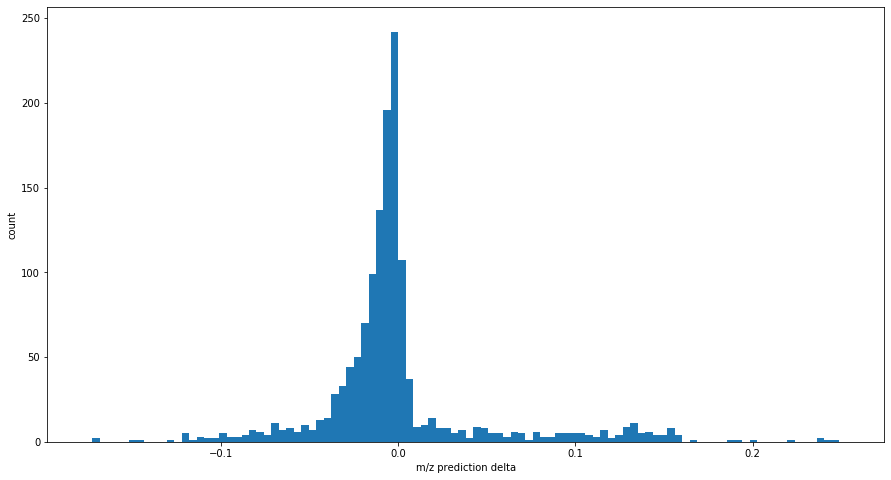

In [29]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 100
hist, bins, _ = plt.hist(y_test_delta, bins=bins, label='m/z delta')
plt.xlabel('m/z prediction delta')
plt.ylabel('count')

plt.show()

In [30]:
# save the trained model
with open('/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/trained-models/file-0-mz-model.pkl', 'wb') as file:
    pickle.dump(best_mz_estimator, file)

scan estimation model (version 1)

In [31]:
X = file_sequence_charge_attribs_df[file_sequence_charge_attribs_df.file_idx == file_idx][['theoretical_mz','experiment_rt','experiment_scan','experiment_intensity']].values
y = file_sequence_charge_attribs_df[file_sequence_charge_attribs_df.file_idx == file_idx]['run_scan'].values

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [33]:
best_scan_estimator = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=17, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [34]:
# use the best parameters to train the model
best_scan_estimator.fit(X_train, y_train)
print("R-squared for training set (best model found): {}".format(best_scan_estimator.score(X_train, y_train)))

R-squared for training set (best model found): 0.999026011699055


In [35]:
# use the trained model to predict the scan for the test set
y_test_predicted = best_scan_estimator.predict(X_test)

In [36]:
y_test_predicted

array([675.23780055, 615.15108145, 366.38826504, ..., 179.27678777,
       638.51784573, 542.69384472])

In [37]:
y_test

array([678.13      , 609.76      , 363.93      , ..., 179.90042044,
       633.2       , 542.01      ])

In [38]:
y_test_delta = np.abs(y_test_predicted) - np.abs(y_test)

In [39]:
np.std(y_test_delta)

8.099110739061425

In [40]:
abs(y_test_delta).max()

152.62094406482862

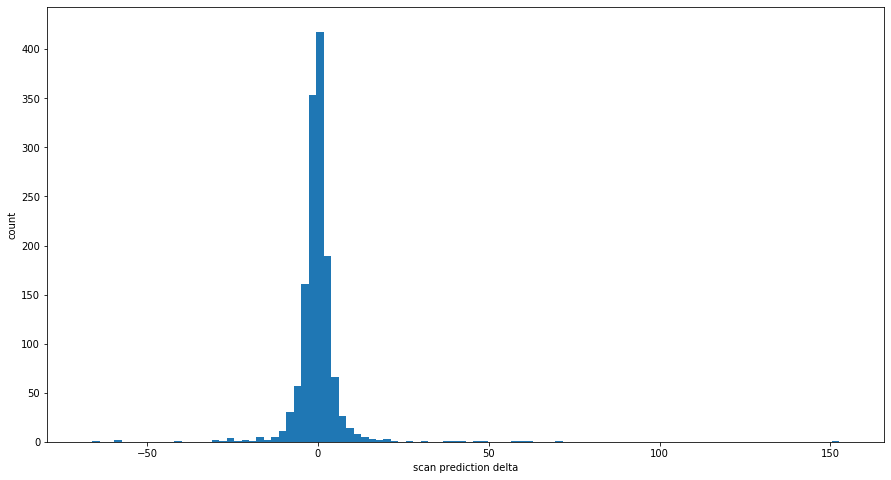

In [41]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 100
hist, bins, _ = plt.hist(y_test_delta, bins=bins, label='m/z delta')
plt.xlabel('scan prediction delta')
plt.ylabel('count')

plt.show()

In [42]:
# save the trained model
with open('/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/trained-models/file-0-scan-model.pkl', 'wb') as file:
    pickle.dump(best_scan_estimator, file)

RT estimation model (version 1)

In [43]:
X = file_sequence_charge_attribs_df[file_sequence_charge_attribs_df.file_idx == file_idx][['theoretical_mz','experiment_rt','experiment_scan','experiment_intensity']].values
y = file_sequence_charge_attribs_df[file_sequence_charge_attribs_df.file_idx == file_idx]['run_rt'].values

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [45]:
best_rt_estimator = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=17, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [46]:
# use the best parameters to train the model
best_rt_estimator.fit(X_train, y_train)
print("R-squared for training set (best model found): {}".format(best_rt_estimator.score(X_train, y_train)))

R-squared for training set (best model found): 0.999533907174205


In [47]:
# use the trained model to predict the scan for the test set
y_test_predicted = best_rt_estimator.predict(X_test)

In [48]:
y_test_predicted

array([ 665.60790993,  427.85274724,  705.57473271, ...,  501.24111729,
       1044.67495425,  560.61572885])

In [49]:
y_test

array([ 665.07      ,  429.64441909,  705.15      , ...,  503.10523037,
       1046.21      ,  559.84      ])

In [50]:
y_test_delta = np.abs(y_test_predicted) - np.abs(y_test)

In [51]:
np.std(y_test_delta)

12.628610070005537

In [52]:
abs(y_test_delta).max()

400.0794543770142

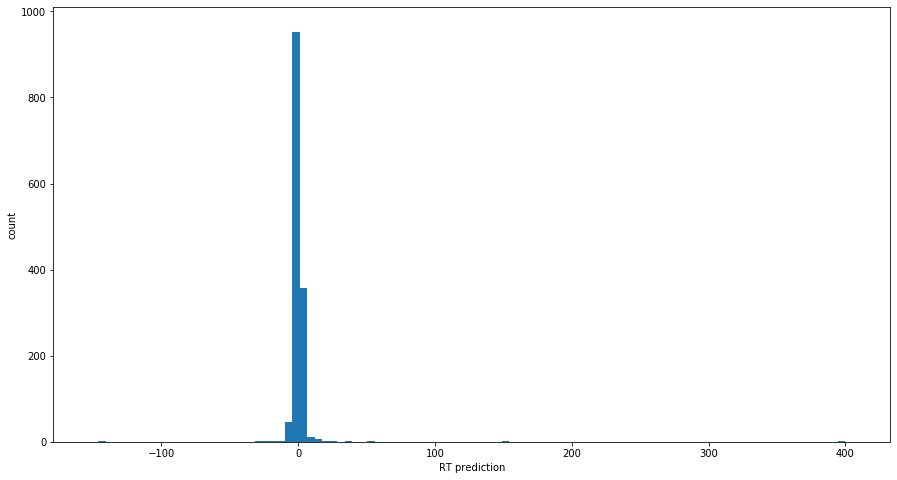

In [53]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 100
hist, bins, _ = plt.hist(y_test_delta, bins=bins, label='m/z delta')
plt.xlabel('RT prediction')
plt.ylabel('count')

plt.show()

In [54]:
# save the trained model
with open('/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/trained-models/file-0-rt-model.pkl', 'wb') as file:
    pickle.dump(best_rt_estimator, file)